In [ ]:
import torch
import warnings

from huggingface_hub import hf_hub_download
from src.model.SaTformer.SaTformer import SaTformer
from src.dataloader.challenge_one_dataloader import Sat2RadDataset

# quiet some annoying UserWarnings thrown by xarray 
# when opening datasets with phony_dims=None
warnings.simplefilter("ignore")

model = SaTformer(
    dim=512,
    num_frames=4,       # number HRIT input frames
    num_classes=64,     # number precipitation bins to use
    image_size=32,      # HRIT input spatial dimensions
    patch_size=4,
    channels=11,        # number HRIT radiance channels
    depth=12,           # number transformer encoder blocks
    heads=8,
    dim_head=64,
    attn_dropout=0.1,
    ff_dropout=0.1,
    rotary_emb=False,   # i.e., use postitional embeds
    attn="ST^2"
)

WEIGHTS_FP = hf_hub_download(repo_id="leharris3/satformer", filename="sf-64-cls.pt")
SAMPLE_FP  = "assets/high_rain_event.pth"

item = torch.load(SAMPLE_FP)

model.load_state_dict(torch.load(WEIGHTS_FP, weights_only=True), strict=False);
model.eval()

with torch.no_grad():
    inputs = item["X_norm"].unsqueeze(0)  # an acutal HRIT input
    logits = model(inputs)                # call model forward pass
    print(logits.shape)                   # -> [1, 64]; raw model probs over output classes

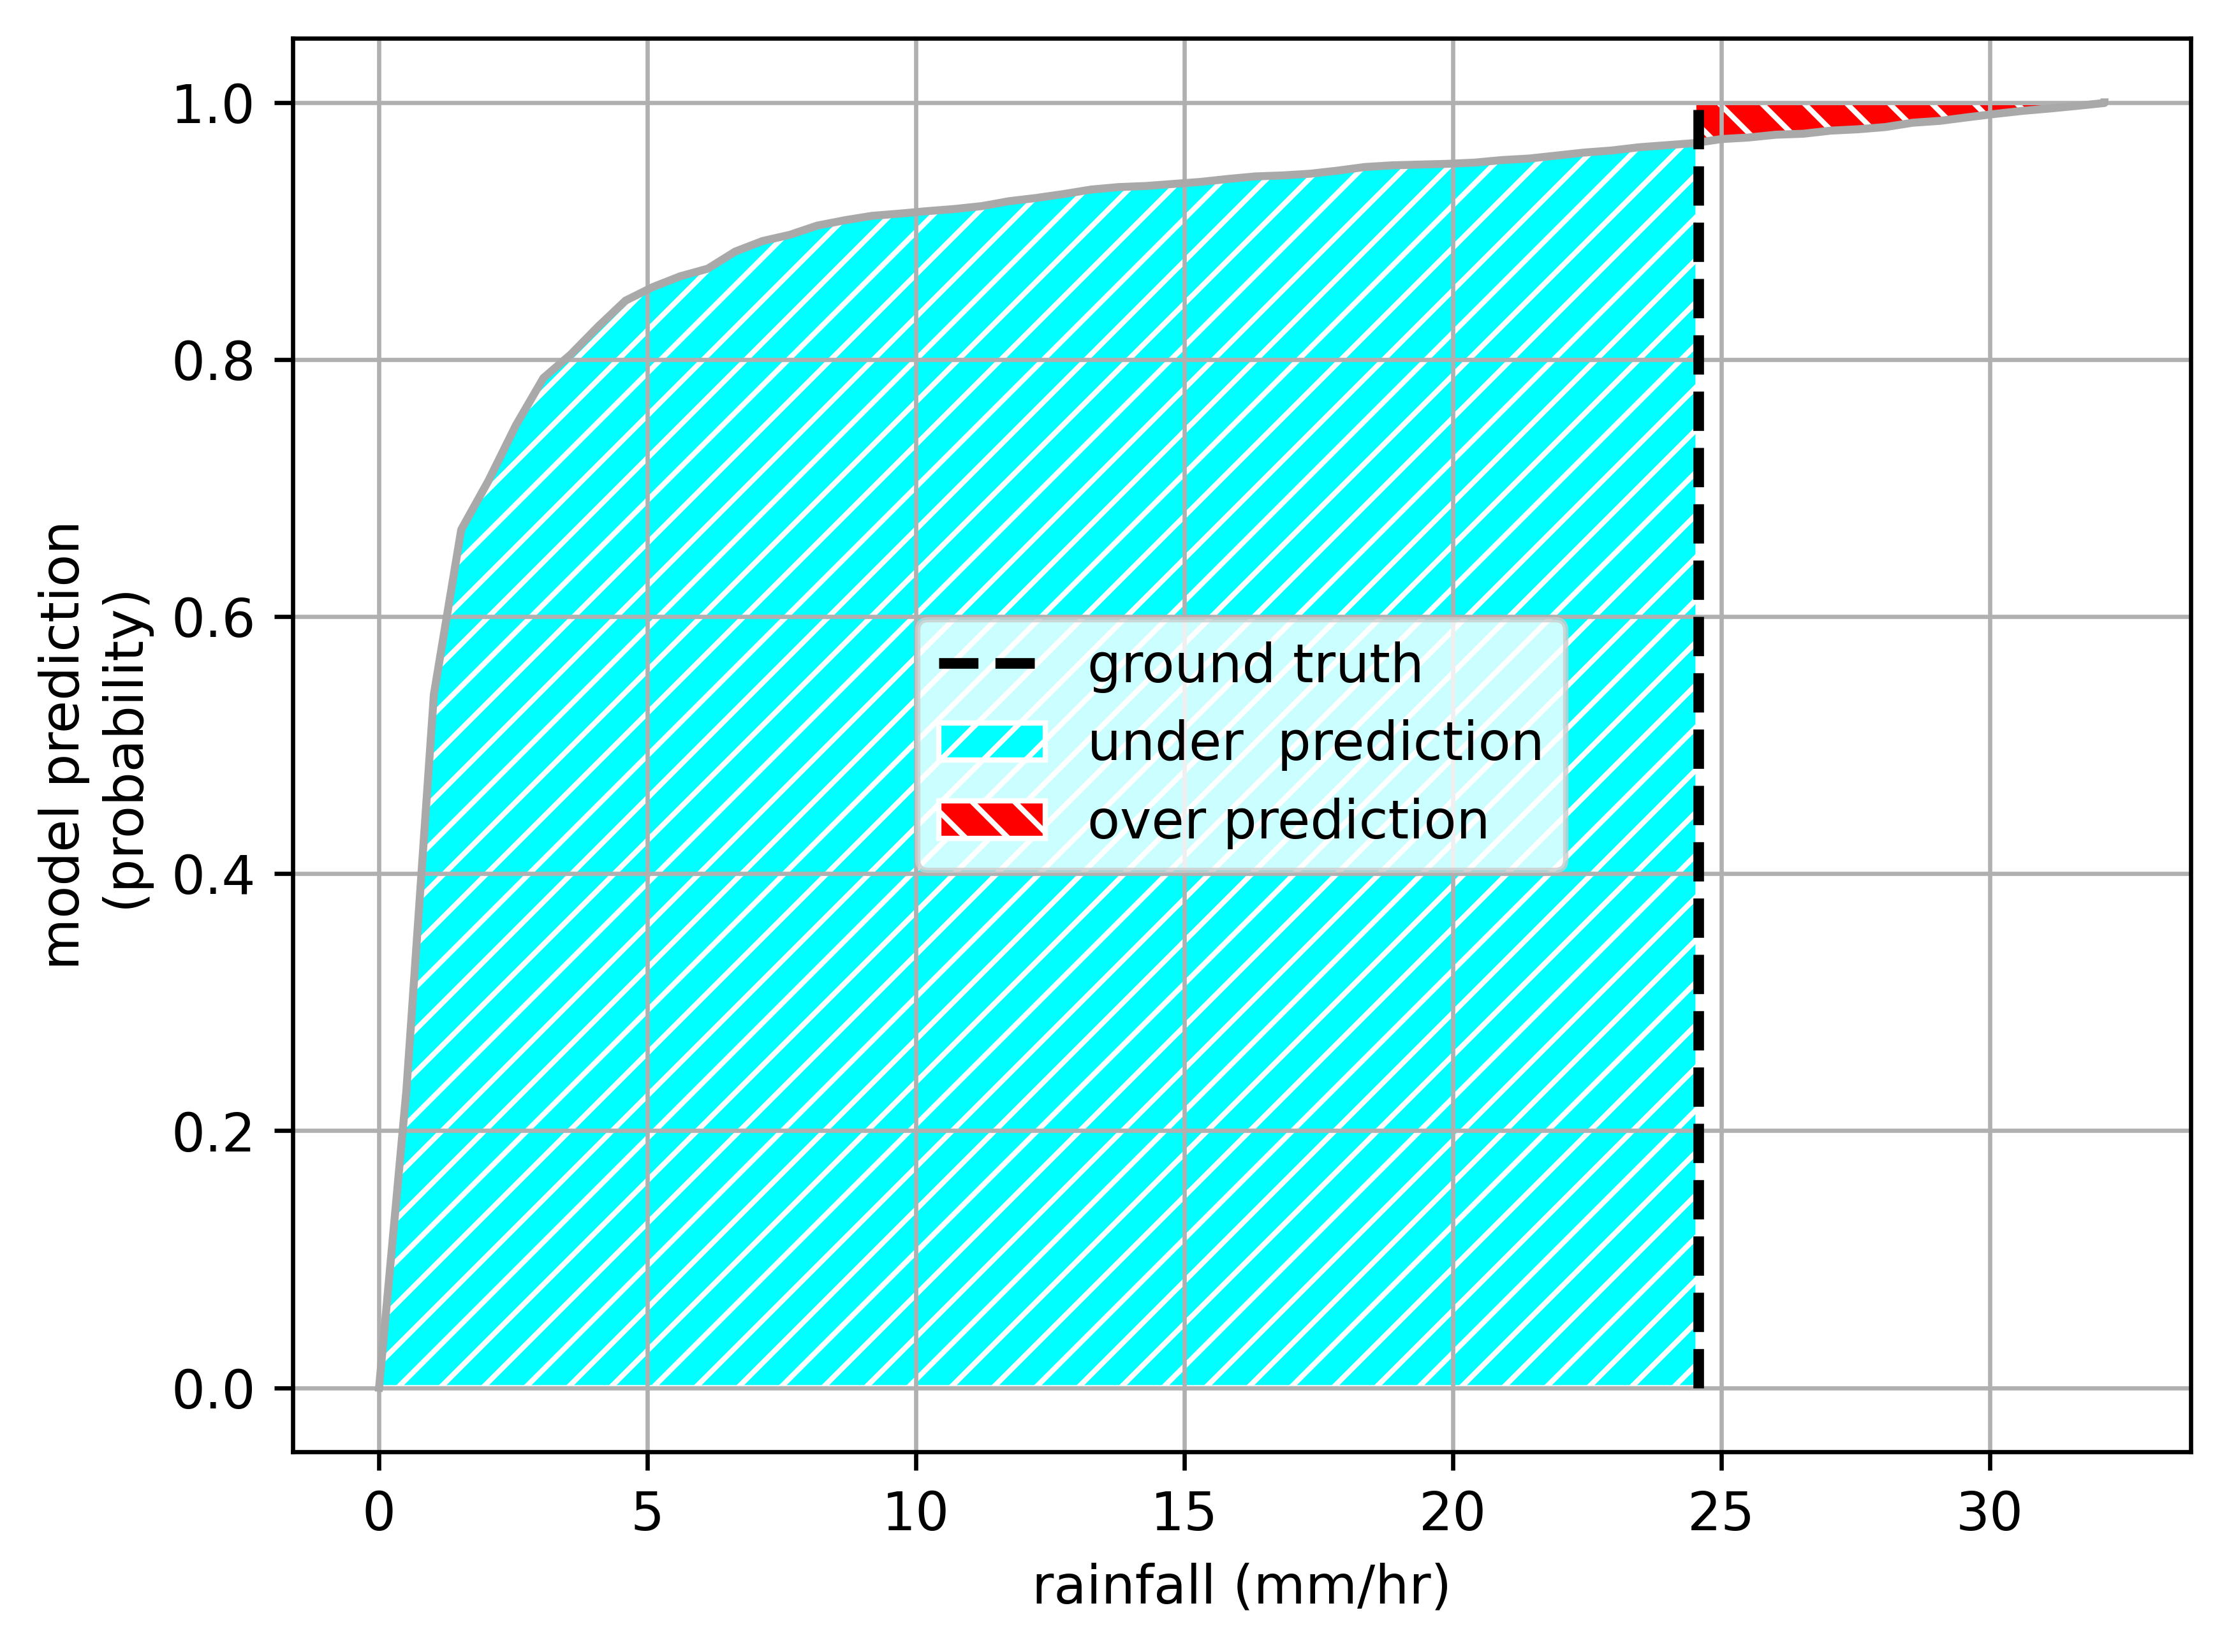

In [20]:
import matplotlib.pyplot as plt
from src.dataloader.dataset_stats import Y_REG_MAX
from src.dataloader.challenge_one_dataloader import get_y_reg_bin_counts_step


# ground-truth label
label = item["y_reg"]

# plot a cmf of our models predicted precipitation bins
probabilities = torch.nn.functional.softmax(logits, dim=-1)[0, ...]
cmf = probabilities.cumsum(dim=-1)
cmf = torch.cat([torch.tensor([0.0]), cmf])

# get precipitation bins
bins, _, _ = get_y_reg_bin_counts_step(64)
bins *= Y_REG_MAX     # -> rescale to original mm/hr

bins = list(bins)
bins.append(bins[-1]) # for plotting purposes
bins = torch.tensor(bins)

fig, ax = plt.subplots(dpi=600)

ax.set_xlabel("rainfall (mm/hr)")
ax.set_ylabel("model prediction\n(probability)")

ax.grid()
ax.plot(bins, cmf, color="darkgray");
ax.vlines([label], 0, 1.0, colors="black", label="ground truth", linestyle="--", linewidth=2.0)

up_idx = bins[bins < label].argmax()
underpred_x = list(bins[:up_idx]); underpred_x.append(label.item())
underpred_y = list(cmf[:up_idx]);  underpred_y.append(.97)

overpred_x = list(bins[up_idx: ])
overpred_y = list(cmf[up_idx:  ])

# hatch: {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}
ax.fill_between(underpred_x, torch.zeros(len(underpred_y)), underpred_y,  hatch="///"  , color="cyan", edgecolor='white', label="under  prediction")
ax.fill_between(overpred_x , overpred_y, torch.ones(len(overpred_y))  ,  hatch="\\\\\\", color="red", edgecolor='white',  label="over prediction")
ax.legend();